# Imports

In [1]:
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo import draw
from Bio import SeqIO
from Bio import Phylo, AlignIO
import subprocess
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns; sns.set(color_codes=True)
from sklearn.cluster import AgglomerativeClustering

# Read sequence data and metadata
Read in the SARS-CoV-2 multiple sequence alignment.

12 SARS-CoV-2 genomic sequences from different locations and hosts were retrieved from NCBI Virus and aligned using the alignment function provided by the platform (https://www.ncbi.nlm.nih.gov/labs/virus/vssi/).

MSA.fasta was created by replacing the sequence header of the downloaded ncbi msa file with only the accession id and the file suffix -aln with .fasta.

In [23]:
align = AlignIO.read("MSA.fasta", "fasta")
print(align)

SingleLetterAlphabet() alignment with 12 rows and 29930 columns
ATATTAGGTTTTTACCTTCCCAGGTAACAAACCAACTAACTCTC...AAA MG772933.1
---------------------------------------CTTTC...--- MT451694.1
----------------------------------ACCAACTTTC...--- MT658507.1
--TAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT641501.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT350282.1
---------TTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT263074.1
----------------------------------------TTTC...--- MT576584.1
------------------------------------------TC...--- MT635269.1
--------------------------------------------...--- MT582453.1
--------------------------------------------...--- MT525950.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MN908947.3
--------------------------------------ACTTTC...--- MT641645.1


### Process metadata 

The metadata file was downloaded from https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&ids=MN908947%20MG772933%20MT658507%20MT576584%20MT582453%20MT525950%20MT641501%20MT350282%20MT263074%20MT641645%20MT451694%20MT635269 .

For TreeTime and Nextstrain augur:
- matched MSA sequence names and accession ids in  metadata file
- renamed collection date column in metadata to "date" (datetime format)


For Nextstrain augur refine:
- created the columns "strain" and "virus" in addition to "date" (strain = accession, virus = species)
(https://nextstrain.org/docs/tutorials/zika)

In [19]:
accession_metainfo = pd.read_csv("original_data/sequences.csv")

accession_metainfo.rename(columns={'Collection_Date':'date'}, inplace=True)
accession_metainfo.date = pd.to_datetime(accession_metainfo.date, format='%Y-%m-%d')

# TreeTime and augur require the alignment file and metadata to have matching sequence names
new_names = []
for elem in accession_metainfo.Accession.values:
    if elem.startswith('MN'):
        new_names.append(elem+'.3')
    else:
        new_names.append(elem+'.1')
accession_metainfo.Accession = new_names

# Nextstrain augur requires the metadata columns strain, virus and date
accession_metainfo['strain'] = accession_metainfo.Accession
accession_metainfo['virus'] = accession_metainfo.Species

# for auspice
country = []
region = []
for c in accession_metainfo.Geo_Location.values:
    if ':' in c:
        tmp = c.split(':')
        country.append(tmp[0])
        region.append(tmp[1])
    else:
        country.append(c)
        region.append('no_data')
        
accession_metainfo['country'] = country
accession_metainfo['region'] = region

accession_metainfo.to_csv("sequence_metadata.tsv", sep='\t')

In [20]:
accession_metainfo = pd.read_csv("sequence_metadata.tsv", sep='\t', index_col=0)

# Infer phlyogeny
### Based on the MSA, a distance matrix is calculated for the 12 SARS-CoV2 sequences using the identity substitution model.

The identity substitution model assumes that each RNA base can only be maximally similar to itself but not transform into another base. Based on this assumption, two positions in a genomic MSA can only be considered identical (score = 1) or different (score = 0).

- Reading alignments, computing distance matrix, applying and visualizin UPGMA-inferred phylogeny: https://github.com/simonjuleseric2/covid_sequence/blob/master/coronavirus_sequence_analis.ipynb


In [24]:
calculator = DistanceCalculator('identity')
# output = diagonal distance matrix
dm = calculator.get_distance(align)

### Infer phylogeny using the UPGMA algorithm

UPGMA:
- distance based
- bottom-up hierarchical
- assumes a constant mutation rate

Goal:
- get general phylogeny of the SARS-CoV-2 genomes only based on sequence distance

In [25]:
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

code=accession_metainfo["Accession"]
host=accession_metainfo["Host"]
loc=accession_metainfo["Geo_Location"]

In [26]:
# function for mapping the country to the leaf labels in the phylogenetic tree
def get_label(leaf):
    searchname=leaf.name
    for i in range(0, len(code)):
        if searchname==code[i]:
            name=host[i] + ": " + loc[i]
            return name

In [27]:
print(tree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner11')
        Clade(branch_length=0.05995839249916471, name='Inner10')
            Clade(branch_length=0.0024567741396591784, name='Inner9')
                Clade(branch_length=0.0014518250918810795, name='Inner7')
                    Clade(branch_length=0.000801871032408974, name='Inner1')
                        Clade(branch_length=0.0001002338790511148, name='MN908947.3')
                        Clade(branch_length=0.0001002338790511148, name='MT350282.1')
                    Clade(branch_length=0.00036752422318747646, name='Inner4')
                        Clade(branch_length=0.0005345806882726123, name='MT263074.1')
                        Clade(branch_length=0.0005345806882726123, name='MT641501.1')
                Clade(branch_length=0.0012471809221516646, name='Inner8')
                    Clade(branch_length=0.0005951386568660497, name='Inner2')
                        Clade(branch_length=0.0003508185766789018, name='MT525

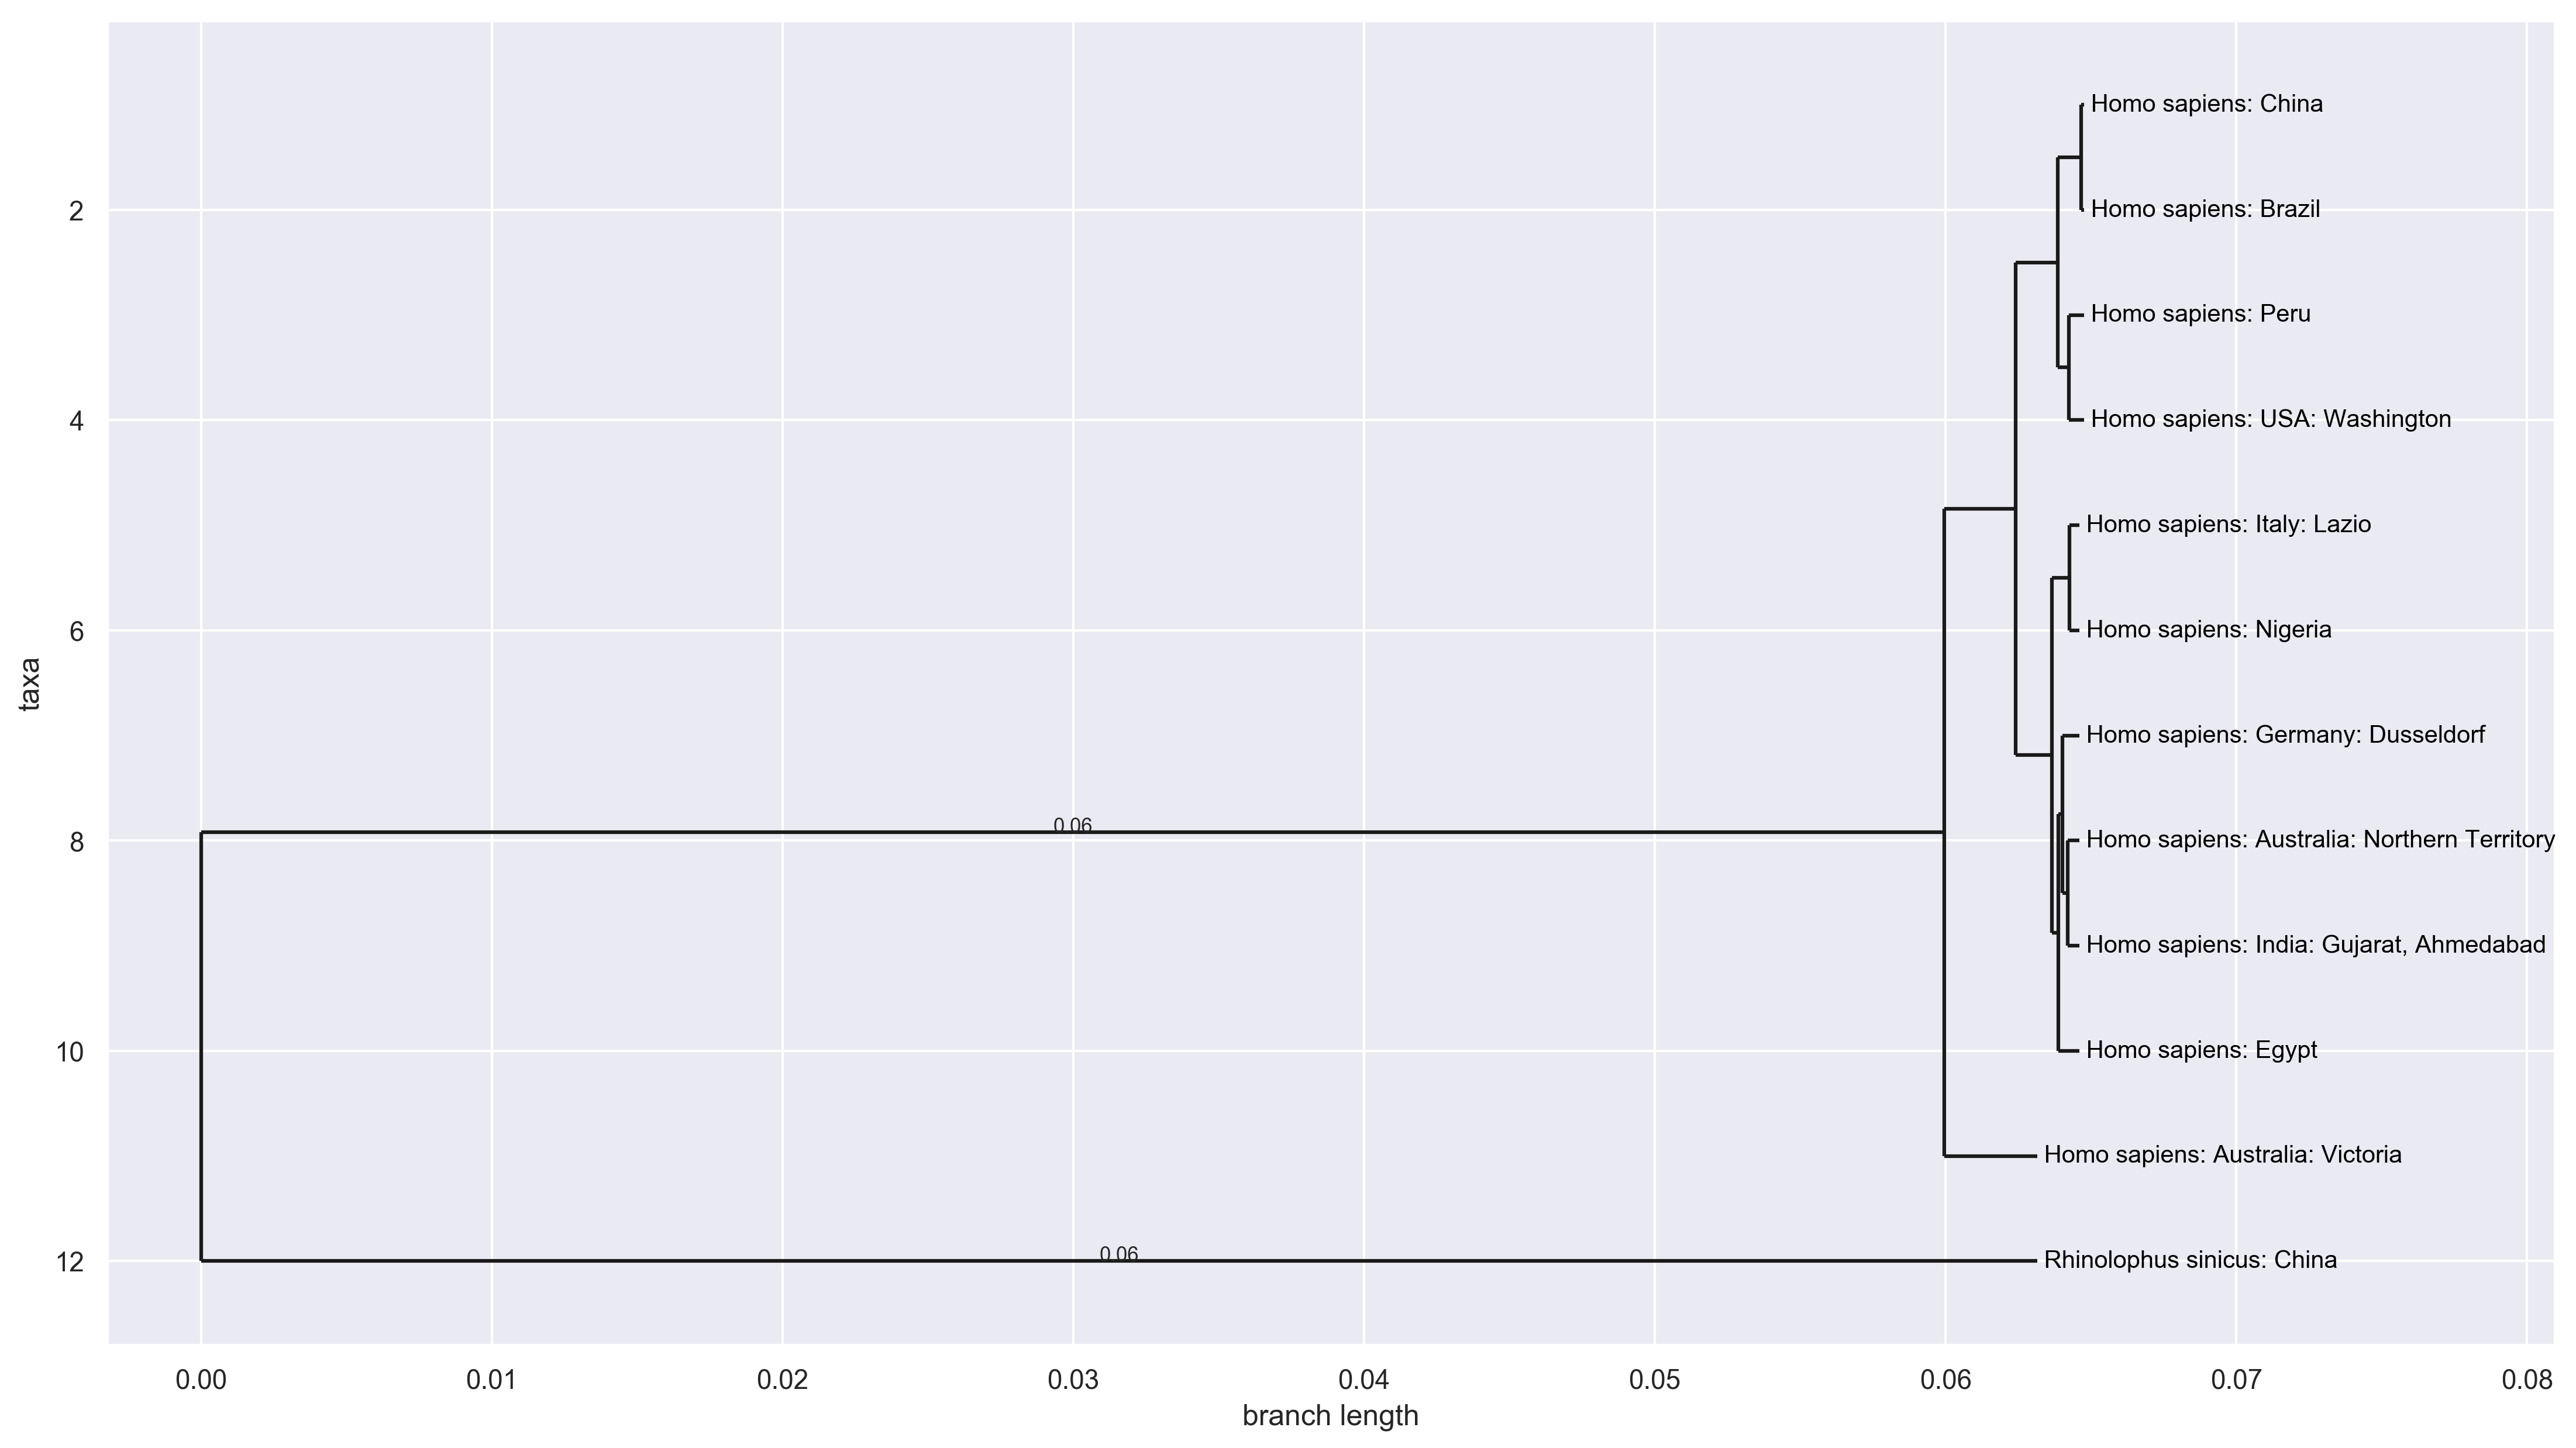

In [31]:
fig = plt.figure(figsize=(18, 10), dpi=300)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(tree, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)
plt.savefig('UPGMA_tree.png')


### Infer phyolgeny using the TreeTime algorithm
__1. OBOSOLETE: TreeTime__ (Maximum Likelihood method):
- https://treetime.readthedocs.io/en/latest/tutorials.html
- temporally-resolved phylogeny
- considers the sequence alignments and is not solely based on sequential distance measures
- estimates the likelihood of a given tree topology to have produced the underlying data assuming a given model of evolution (relaxed-clock)
- evolutionary models provide time-dependent mutation probabilities
- reports topology with the highest likelihood (trees are scored)
- uses iqtree

TreeTime was installed with pip and used as command line program.<br>
__Execution__:<br>
treetime --aln MSA.fasta --dates sequences_metadata.csv --date-column date --name-column Accession --outdir treetime_out
<br>
__The results were not interpreted, instead augur was used for the phylogenetic analysis since it was faster to integrate with the NExtstrain visualization tool.__

__2. Nextstrain:__
- https://nextstrain.org/docs/getting-started/introduction
- open-source tool for analysing and visualizing pathogen evolution and epidemiological spread
- for the purpose of scientific insights and improving outbreak respones in public health 
- Augur is the bioinformtaics toolkit of Nextstrain, Auspice is the visualization toolkit (https://docs.nextstrain.org/projects/augur/en/stable/usage/cli/refine.html)
- uses iqtree for phylogeny inference and treetime algorithm for refinement

Nextstrain augur and iqtree were installed using:<br>
!pip3 install nextstrain-augur and brew install brewsci/bio/iqtree<br>
Nextstrain auspice was installed using a conda environment (https://nextstrain.github.io/auspice/)


For sequence analysis and visualization the Zika tutorial on the Nextstrain website is an easy to follow example: https://nextstrain.org/docs/tutorials/zika.

__Execution__(run in augur_out/):<br>
1. Infer phylogeny from MSA: <br>
augur tree --alignment ../MSA.fasta --method iqtree --output augur.out.nwk 

- Get a time-resolved tree: <br>
augur refine --alignment ../MSA.fasta --tree augur.out.nwk --metadata ../sequence_metadata.csv --output-tree augur.out.refined.nwk --output-node-data augur.refine.branches.json --timetree 

- Annotate the tree with ancestral traits: <br>
augur traits --tree augur.out.refined.nwk --metadata ../sequence_metadata.csv --output traits.json --columns country region Host --confidence 
- Infer ancestral sequence for each internal node (trace back mutations): <br>
augur ancestral --tree augur.out.refined.nwk --alignment ../MSA.fasta --output-node-data nt_muts.json --inference joint
- export to auspice format:<br> 
augur export v2 --tree augur.out.refined.nwk --metadata ../sequence_metadata.tsv --node-data augur.refine.branches.json traits.json nt_muts.json --output auspice/SARS-CoV2.json --geo-resolutions country --color-by-metadata country  Host --colors auspice/config/colors.tsv --lat-longs auspice/config/lat_longs.tsv
<br> The config files for coloring and latidues/longitudes were generated following the config files in the github repo of the zika tutorial (https://github.com/nextstrain/zika-tutorial.git)


### Visualize phylogeny using Nextstrain auspice
Install: https://nextstrain.github.io/auspice/introduction/install

__Run in command line:__(run in augur_out/)<br>
auspice view --datasetDir auspice


In [32]:
augur = Phylo.read('augur_out/augur.out.refined.nwk', 'newick')

In [33]:
print(augur)

Tree(rooted=False, weight=1.0)
    Clade(branch_length=0.001, name='NODE_0000002')
        Clade(branch_length=0.06425789, name='MG772933.1')
        Clade(branch_length=0.0657612, name='NODE_0000000')
            Clade(branch_length=0.00029019, name='MT641501.1')
            Clade(branch_length=8.597e-05, name='NODE_0000001')
                Clade(branch_length=1.38e-06, name='NODE_0000006')
                    Clade(branch_length=0.0, name='MN908947.3')
                    Clade(branch_length=3.381e-05, name='NODE_0000003')
                        Clade(branch_length=0.00013217, name='MT350282.1')
                        Clade(branch_length=9.224e-05, name='MT641645.1')
                Clade(branch_length=8.481e-05, name='NODE_0000004')
                    Clade(branch_length=0.00019926, name='MT658507.1')
                    Clade(branch_length=1.161e-05, name='NODE_0000005')
                        Clade(branch_length=7.401e-05, name='MT582453.1')
                        Clade(bran

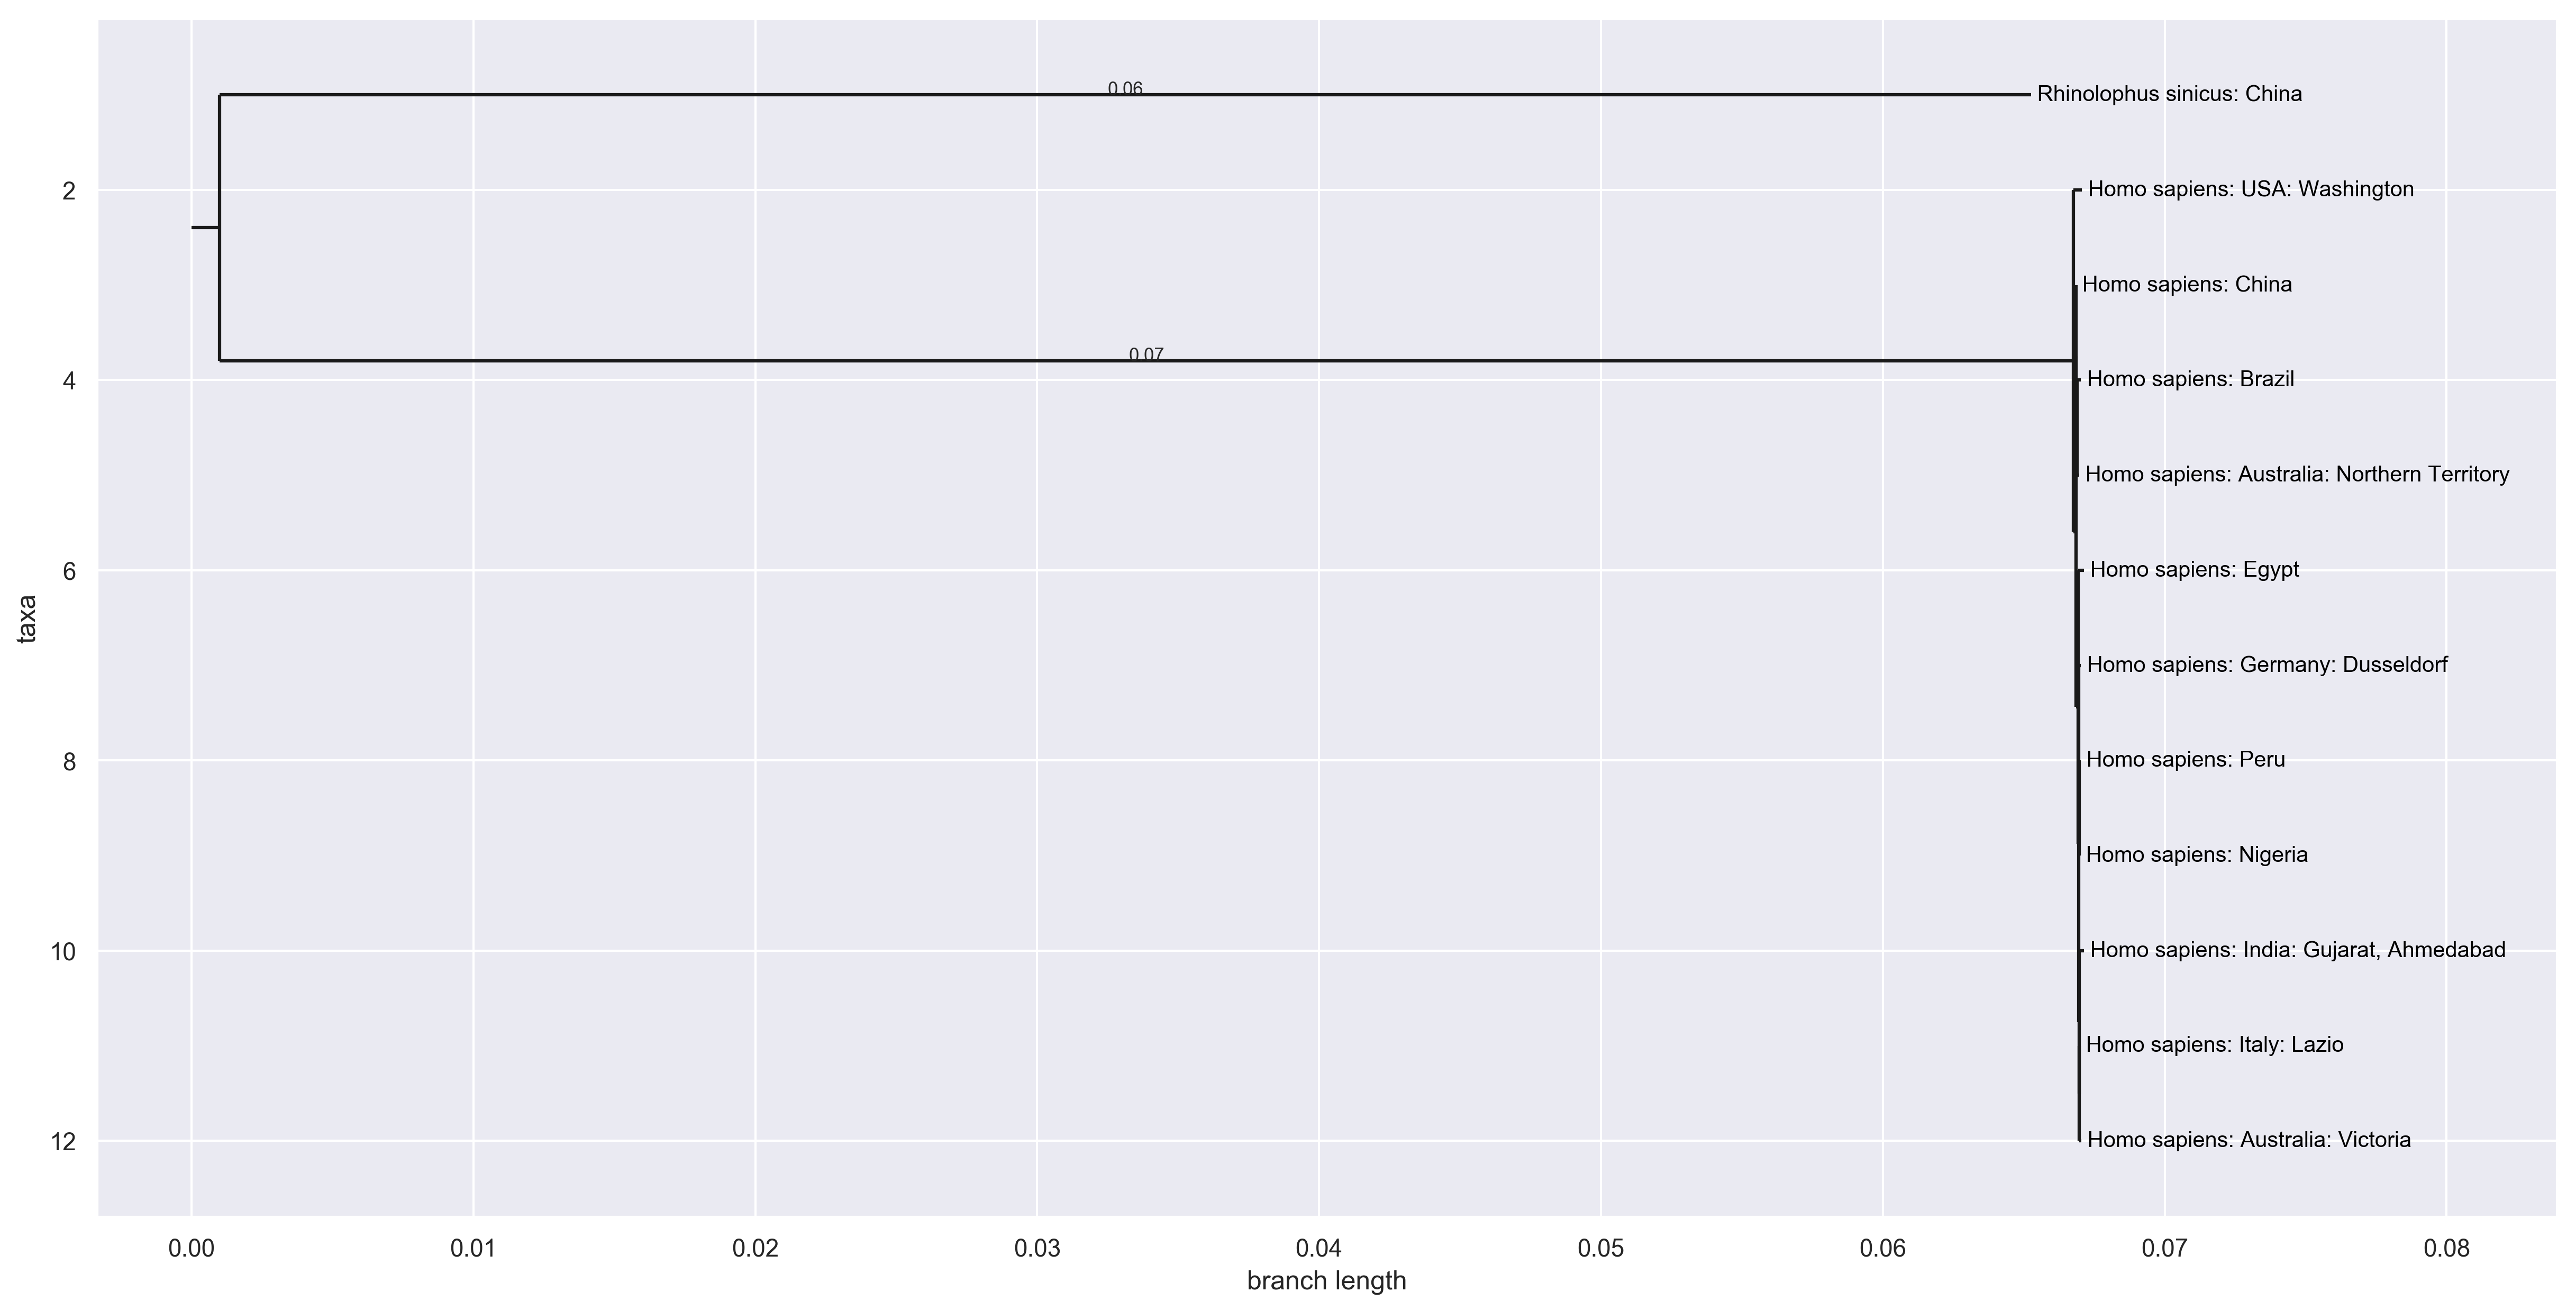

In [34]:
fig = plt.figure(figsize=(20, 10), dpi=300)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(augur, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)
plt.savefig('augur_out/augur_refined_tree.png')

In [35]:
treetime = Phylo.read('treetime_out/timetree.nexus', 'nexus')

In [36]:
print(treetime)

Tree(name='tree1', rooted=False, weight=1.0)
    Clade(branch_length=0.1, name='NODE_0000002')
        Clade(branch_length=91.69225, name='MG772933.1')
        Clade(branch_length=94.38823, name='NODE_0000000')
            Clade(branch_length=0.49505, name='MT641501.1')
            Clade(branch_length=0.13417, name='NODE_0000001')
                Clade(branch_length=-0.0, name='MN908947.3')
                Clade(branch_length=0.06353, name='NODE_0000003')
                    Clade(branch_length=0.23178, name='MT350282.1')
                    Clade(branch_length=0.16075, name='MT641645.1')
                Clade(branch_length=0.13952, name='NODE_0000004')
                    Clade(branch_length=0.24467, name='MT635269.1')
                    Clade(branch_length=0.05947, name='NODE_0000005')
                        Clade(branch_length=0.07446, name='MT263074.1')
                        Clade(branch_length=0.04987, name='MT576584.1')
                    Clade(branch_length=0.04526, name='N

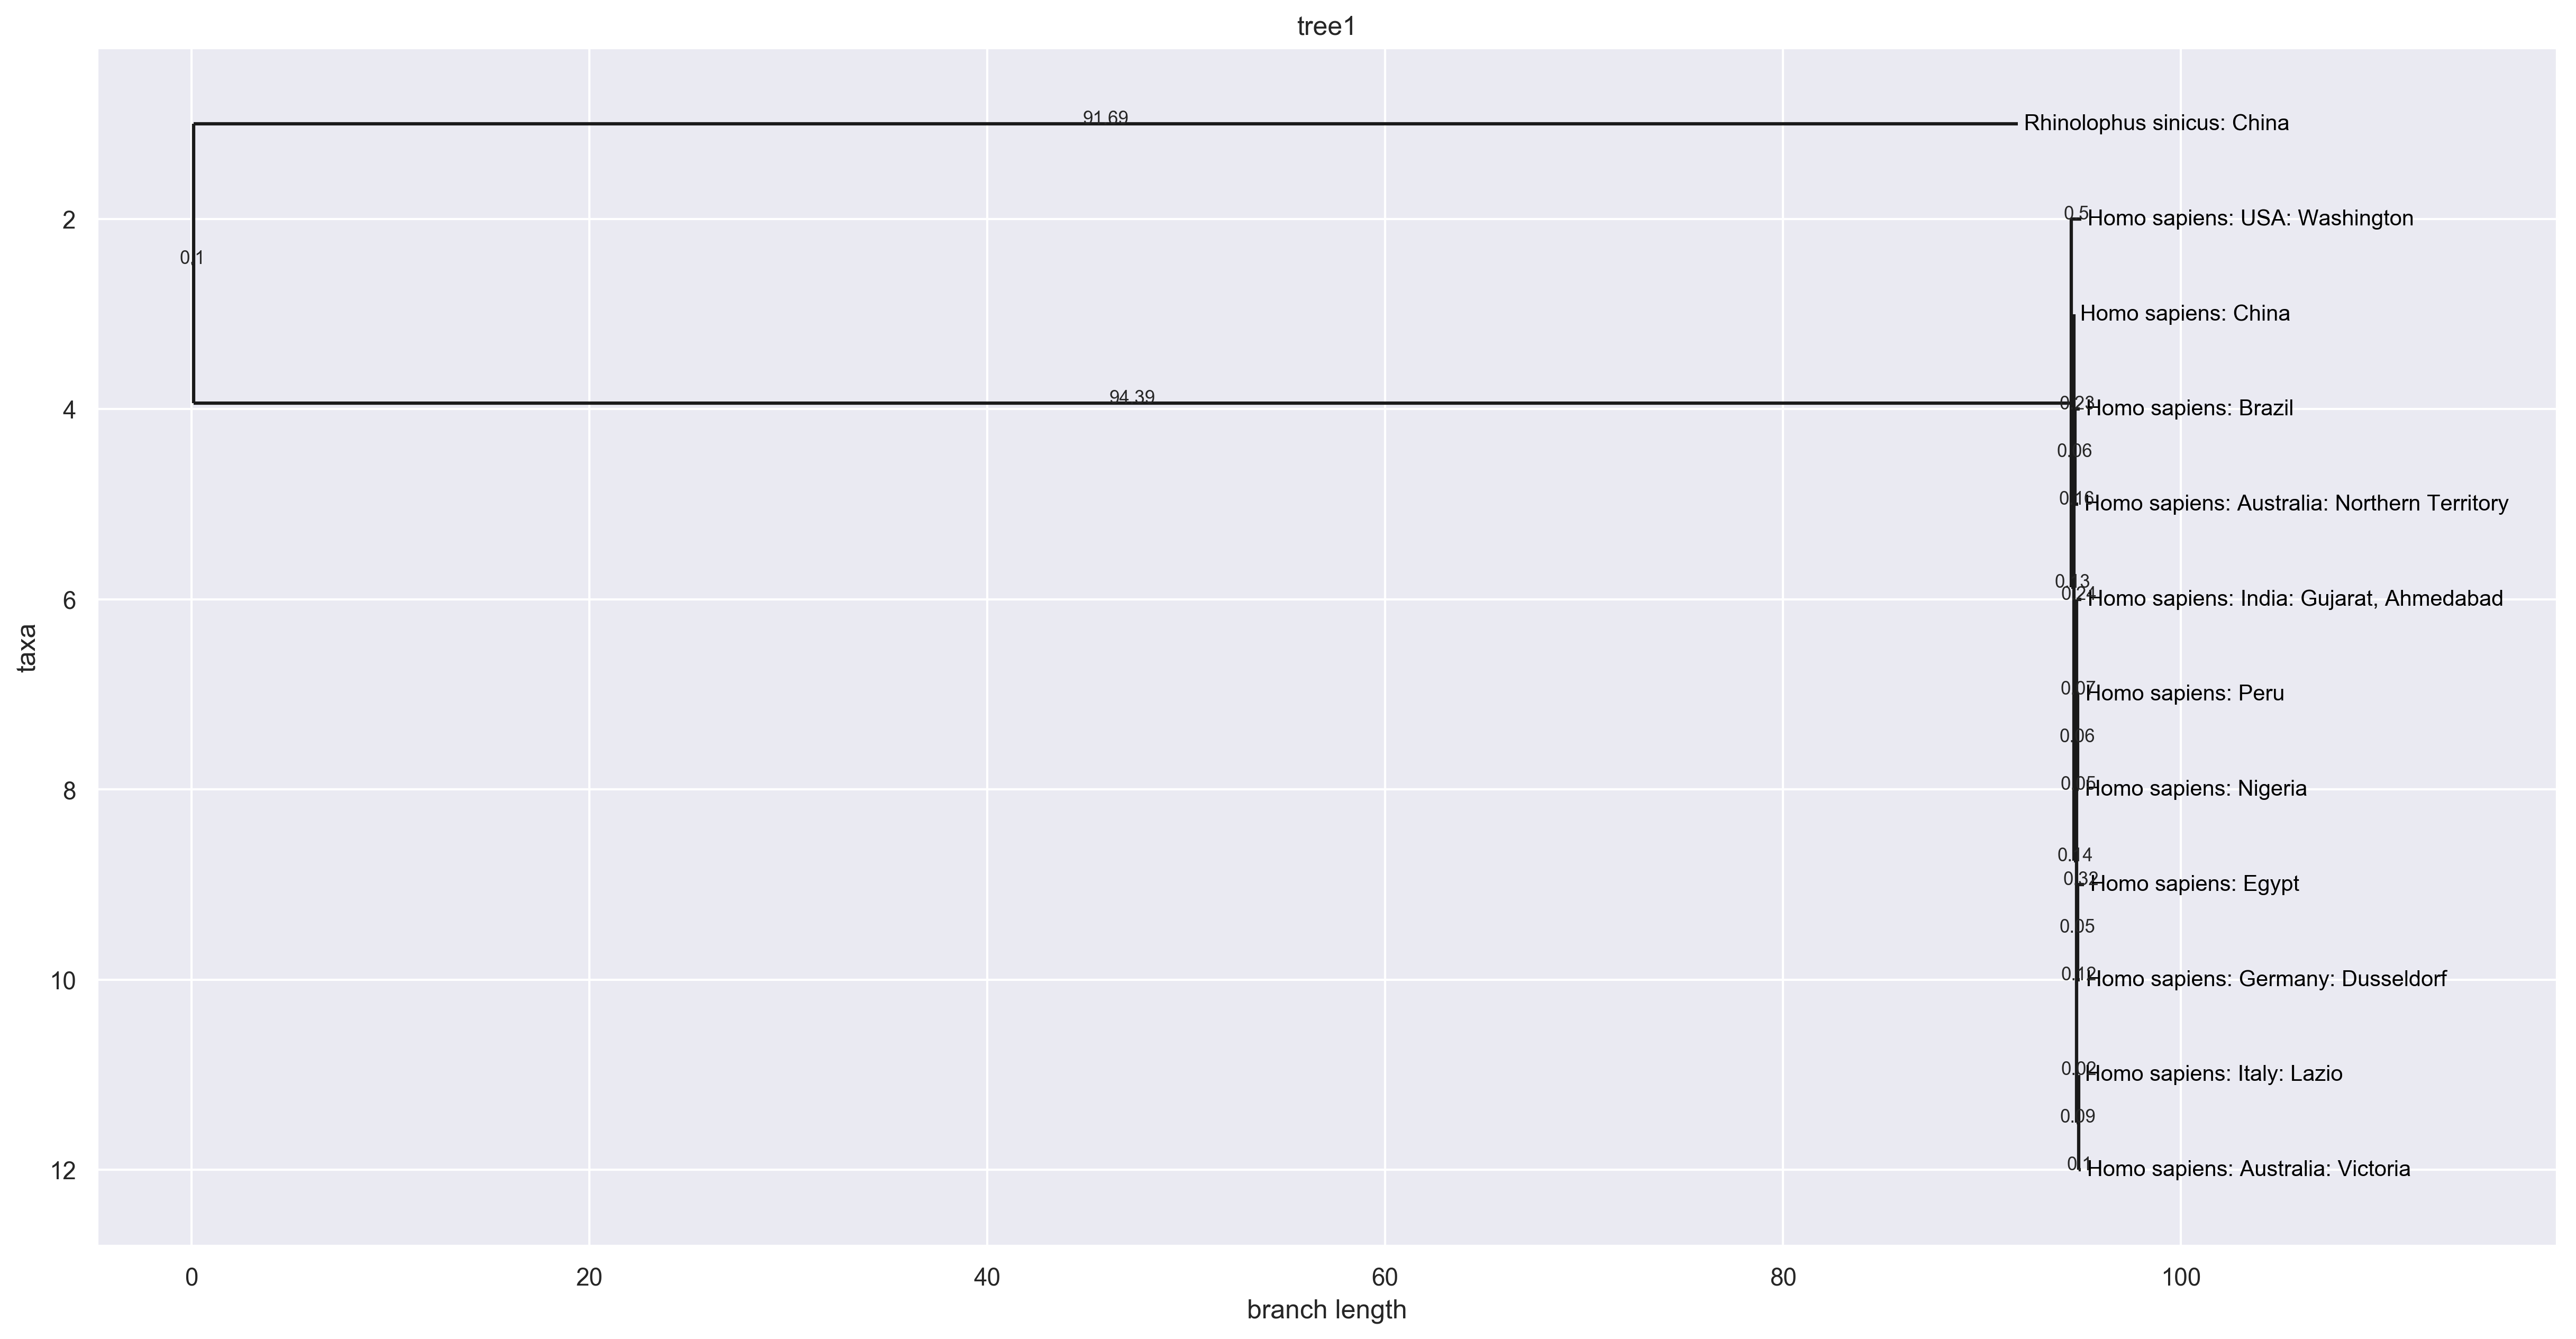

In [37]:
fig = plt.figure(figsize=(20, 10), dpi=300)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(treetime, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)


# Cluster analysis

TODO: Employ some evaluation metrix for cluster analysis (e.g. silhouette coefficient, number of clusters, cluster sizes...)
### Cluster analysis for sequences from tasks 1 and 2
Using Agglomerative hierarchical clustering using distance matrix as affinity metric.<br>
Excluded bat sequence from analysis.<br>

In [6]:
calculator = DistanceCalculator('identity')
# output = diagonal distance matrix
dm = calculator.get_distance(align[1:])

In [7]:
X = np.array(dm)
clustering = AgglomerativeClustering(affinity='precomputed',linkage='average').fit_predict(X)

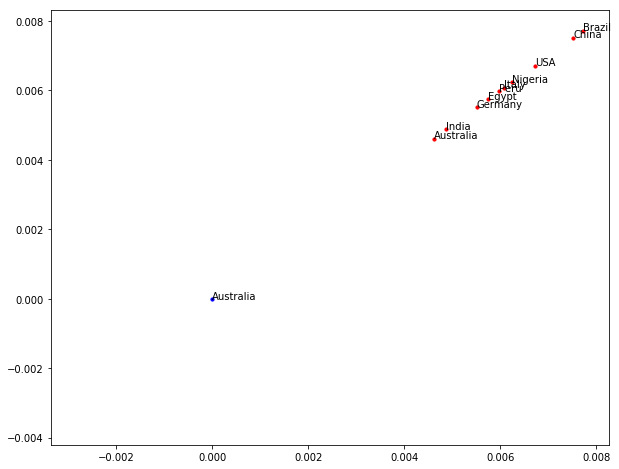

In [11]:
plt.figure(figsize=(10,8))
ax = plt.scatter(X[np.where(clustering==1)[0],0],X[0,np.where(clustering==1)[0]], s=10,c='blue')
plt.scatter(X[np.where(clustering==0)[0],0],X[0,np.where(clustering==0)[0]], s=10,c='red')
for i, txt in enumerate(dm.names):
    plt.annotate(accession_metainfo[accession_metainfo.Accession == txt].country.values[0], (X[i,0],X[0,i]))
plt.show()

### Cluster analysis within Germany

In [46]:
align_germany = AlignIO.read("../Paul/clustering/MSA_Germany.fasta", "fasta")
print(align_germany)

SingleLetterAlphabet() alignment with 16 rows and 29903 columns
--------------------------------------------...--- MT582447.1
--------------------------------------------...--- MT582446.1
--------------------------------------------...--- MT582490.1
--------------------------------------------...--- MT582497.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT358638.1
--------------------------------------------...--- MT582498.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT358641.1
--------------------------------------------...--- MT582494.1
--------------------------------------------...--- MT582484.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT358639.1
--------------------------------------------...--- MT582487.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT358643.1
--------------------------------------------...--- MT270108.1
--TAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT270106.1
-----------------------------AACCAACCAACTTTC...--- MT270103.1
------

In [77]:
accession_metainfo_germany = pd.read_csv("../Paul/clustering/germany_metadata.csv", index_col=0)
accession_metainfo_germany.rename(columns={'Collection_Date':'date'}, inplace=True)

# alignment file and metadata need to have matching sequence names
new_names = []
for elem in accession_metainfo_germany.index.values:
    if elem.startswith('MN'):
        new_names.append(elem+'.3')
    else:
        new_names.append(elem+'.1')
accession_metainfo_germany.index = new_names

In [78]:
accession_metainfo_germany.head()

,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,date
MT582446.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-20
MT582447.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-20
MT582484.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-11
MT582487.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-11
MT582490.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Heinsberg,Homo sapiens,NaN,2020-02-28


In [79]:
calculator = DistanceCalculator('identity')
# output = diagonal distance matrix
dm_germany = calculator.get_distance(align_germany)

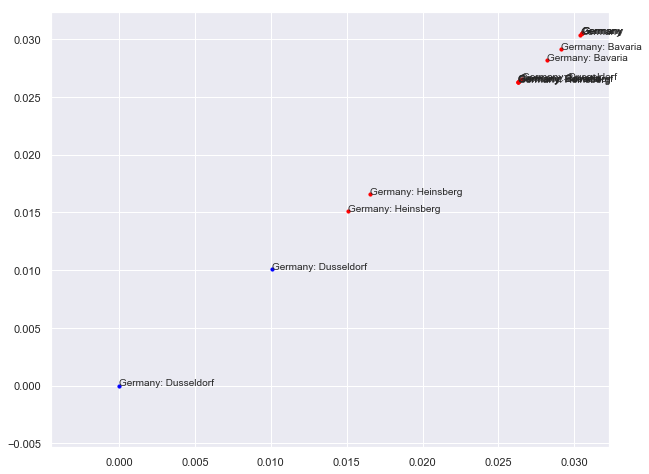

In [80]:
X_germany = np.array(dm_germany)
clustering_germany = AgglomerativeClustering(affinity='precomputed',linkage='average').fit_predict(X_germany)

plt.figure(figsize=(10,8))
ax = plt.scatter(X_germany[np.where(clustering_germany==1)[0],0],X_germany[0,np.where(clustering_germany==1)[0]], s=10,c='blue')
plt.scatter(X_germany[np.where(clustering_germany==0)[0],0],X_germany[0,np.where(clustering_germany==0)[0]], s=10,c='red')
for i, txt in enumerate(dm_germany.names):
    plt.annotate(accession_metainfo_germany[accession_metainfo_germany.index.values == txt].Geo_Location.values[0], (X_germany[i,0],X_germany[0,i]))
plt.show()

In [81]:
clusters_ger = pd.DataFrame(data=dm_germany.names, columns=['Accession'])
clusters_ger['clusters'] = clustering_germany
clusters_ger['Geo_Location'] = [accession_metainfo_germany[accession_metainfo_germany.index ==x].Geo_Location.values[0] for x in clusters_ger.Accession]

In [82]:
clusters_ger

,Accession,clusters,Geo_Location
0,MT582447.1,1,Germany: Dusseldorf
1,MT582446.1,1,Germany: Dusseldorf
2,MT582490.1,0,Germany: Heinsberg
3,MT582497.1,0,Germany: Heinsberg
4,MT358638.1,0,Germany
5,MT582498.1,0,Germany: Heinsberg
6,MT358641.1,0,Germany
7,MT582494.1,0,Germany: Heinsberg
8,MT582484.1,0,Germany: Dusseldorf
9,MT358639.1,0,Germany


In [83]:
# transform the diagonal matrix into a full rank matrix
cols = [accession_metainfo_germany["Geo_Location"][x] for x in dm_germany.names]
df_germany = pd.DataFrame(dm_germany.matrix, columns=cols, index=cols)
maxi = df_germany.shape[0]
for i in range(0,maxi):
    for j in range(i+1,maxi):
        df_germany.iloc[i,j] = df_germany.iloc[j,i]
df_germany.head()

,Germany: Dusseldorf,Germany: Dusseldorf,Germany: Heinsberg,Germany: Heinsberg,Germany,Germany: Heinsberg,Germany,Germany: Heinsberg,Germany: Dusseldorf,Germany,Germany: Dusseldorf,Germany,Germany: Bavaria,Germany: Bavaria,Germany: Bavaria,Germany: Bavaria
Germany: Dusseldorf,0.000000,0.010066,0.015116,0.016554,0.030499,0.026285,0.030398,0.026318,0.026318,0.030532,0.026519,0.030499,0.026419,0.029128,0.028191,0.026352
Germany: Dusseldorf,0.010066,0.000000,0.024914,0.026352,0.040297,0.036016,0.040197,0.036117,0.036117,0.040063,0.036050,0.040029,0.036016,0.038725,0.037789,0.035950
Germany: Heinsberg,0.015116,0.024914,0.000000,0.016286,0.015851,0.011638,0.015617,0.011537,0.011537,0.015885,0.011872,0.015851,0.011771,0.014480,0.013544,0.011705
Germany: Heinsberg,0.016554,0.026352,0.016286,0.000000,0.014079,0.009865,0.013845,0.009765,0.009765,0.014112,0.010099,0.014079,0.009999,0.012708,0.011771,0.009932
Germany,0.030499,0.040297,0.015851,0.014079,0.000000,0.004414,0.000301,0.004314,0.004314,0.000435,0.004515,0.000401,0.004414,0.001639,0.002508,0.004347


/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:597: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


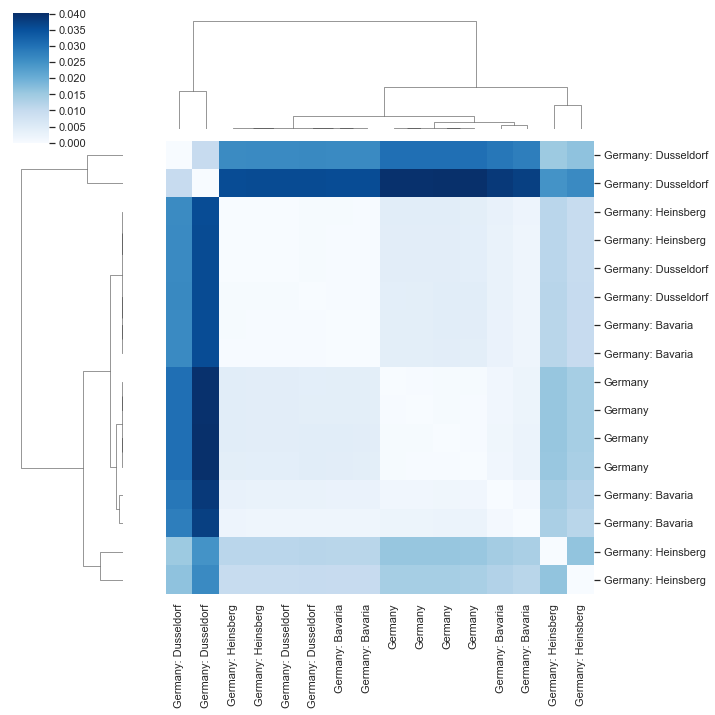

In [84]:
#use the UPGMA scoring for clustering
#linkage = hc.linkage(sp.distance.squareform(df_germany), method="average")
g = sns.clustermap(df_germany, cmap="Blues", method="average")#, row_linkage=linkage, col_linkage=linkage)

In [85]:
print("Mean Identity Distance in Germany:")
print(df_germany.mean().mean())

Mean Identity Distance in Germany:
0.010588663762833163


### Cluster analysis between Europe and Asia

In [86]:
align_eu_vs_asia = AlignIO.read("../Paul/clustering/MSA_EU_vs_Asia.fasta", "fasta")
print(align_eu_vs_asia)

SingleLetterAlphabet() alignment with 20 rows and 29903 columns
--------------------------------------------...--- MT256917.1
-----AGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT372481.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT093571.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT576689.1
------------------------TAACAAACCAACCAACTTTC...--- MT630423.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT470105.1
ATTAAAGGTTTATACCTTTCCAGGTAACAAACCAACCAACTTTC...AAA MT511081.1
-----------ATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT560530.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT328033.1
----------TATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT517422.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT135042.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA LC549340.1
--------------CCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT259230.1
--------------------------------CAACCAACTTTC...--- MT636895.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT358643.1
------

In [88]:
accession_metainfo_eu_vs_asia = pd.read_csv("../Paul/clustering/eu_vs_asia_metadata.csv", index_col=0)

accession_metainfo_eu_vs_asia.rename(columns={'Collection_Date':'date'}, inplace=True)

# alignment file and metadata need to have matching sequence names
new_names = []
for elem in accession_metainfo_eu_vs_asia.index.values:
    new_names.append(elem+'.1')
accession_metainfo_eu_vs_asia.index = new_names

In [90]:
accession_metainfo_eu_vs_asia.head()

,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,date
MT636895.1,2020-06-18T00:00:00Z,Severe acute respiratory syndrome-related coro...,29525,Russia: Moscow region,Homo sapiens,NaN,2020-03-20
MT630423.1,2020-06-17T00:00:00Z,Severe acute respiratory syndrome-related coro...,29814,Saudi Arabia: Jeddah,Homo sapiens,NaN,2020-03-15
MT607604.1,2020-06-15T00:00:00Z,Severe acute respiratory syndrome-related coro...,29800,India: Ahmedabad,Homo sapiens,NaN,2020-06-03
MT598147.1,2020-06-12T00:00:00Z,Severe acute respiratory syndrome-related coro...,888,Iran,Homo sapiens,oronasopharynx,2020-03-10
MT576689.1,2020-06-08T00:00:00Z,Severe acute respiratory syndrome-related coro...,29871,Bangladesh,Homo sapiens,oronasopharynx,2020-05-23


In [91]:
calculator = DistanceCalculator('identity')
# output = diagonal distance matrix
dm_eu_vs_asia = calculator.get_distance(align_eu_vs_asia)


# transform the diagonal matrix into a full rank matrix
cols = [accession_metainfo_eu_vs_asia["Geo_Location"][x] for x in dm_eu_vs_asia.names]
df_eu_vs_asia = pd.DataFrame(dm_eu_vs_asia.matrix, columns=cols, index=cols)
maxi = df_eu_vs_asia.shape[0]
for i in range(0,maxi):
    for j in range(i+1,maxi):
        df_eu_vs_asia.iloc[i,j] = df_eu_vs_asia.iloc[j,i]
df_eu_vs_asia.head()

,Spain: Valencia,Malaysia,Sweden,Bangladesh,Saudi Arabia: Jeddah,France,Poland,Turkey,Greece,Czech Republic,China: Beijing,Japan:Tokyo,"China: Hubei, Wuhan",Russia: Moscow region,Germany,India: Ahmedabad,Iran,Belgium,Serbia,Thailand
Spain: Valencia,0.000000,0.106444,0.106009,0.105675,0.103434,0.106478,0.106678,0.105240,0.105642,0.105341,0.106344,0.106511,0.105140,0.112497,0.106544,0.103100,0.966258,0.973581,0.869578,0.984115
Malaysia,0.106444,0.000000,0.001505,0.002241,0.003344,0.000869,0.001070,0.002006,0.001906,0.002107,0.000836,0.000970,0.001639,0.012908,0.000903,0.003812,0.970137,0.977427,0.872086,0.988028
Sweden,0.106009,0.001505,0.000000,0.001204,0.002876,0.000970,0.001204,0.001304,0.000869,0.001405,0.000936,0.001070,0.000970,0.012440,0.001003,0.003344,0.969735,0.977026,0.871685,0.987627
Bangladesh,0.105675,0.002241,0.001204,0.000000,0.002608,0.001572,0.001471,0.000702,0.000401,0.000736,0.001672,0.001538,0.001304,0.011939,0.001471,0.002809,0.969267,0.976524,0.871117,0.987125
Saudi Arabia: Jeddah,0.103434,0.003344,0.002876,0.002608,0.000000,0.003378,0.003545,0.002107,0.002542,0.002207,0.003210,0.003478,0.002006,0.009999,0.003411,0.001204,0.967328,0.974618,0.869277,0.985185


In [92]:
# manual assignment for grouping the samples by continent
accession_metainfo_eu_vs_asia["Continent"] = ["Asia", "Europe", "Asia", "Asia", "Europe", "Europe", "Europe", "Europe", "Asia", "Asia", "Asia", "Asia", "Europe", "Europe", "Asia", "Europe", "Europe", "Europe", "Asia", "Asia"]
accession_metainfo_eu_vs_asia["Continent"].value_counts()

Europe    10
Asia      10
Name: Continent, dtype: int64

In [93]:
accession_metainfo_eu_vs_asia[["Geo_Location","Continent"]]

,Geo_Location,Continent
MT636895.1,Russia: Moscow region,Asia
MT630423.1,Saudi Arabia: Jeddah,Europe
MT607604.1,India: Ahmedabad,Asia
MT598147.1,Iran,Asia
MT576689.1,Bangladesh,Europe
LC549340.1,Japan:Tokyo,Europe
MT560530.1,Turkey,Europe
MT517422.1,Czech Republic,Europe
MT511081.1,Poland,Asia
MT502908.1,Thailand,Asia


In [94]:
X_eu_vs_asia= np.array(dm_eu_vs_asia)
clustering_eu_vs_asia = AgglomerativeClustering(affinity='precomputed',linkage='average').fit_predict(X_eu_vs_asia)

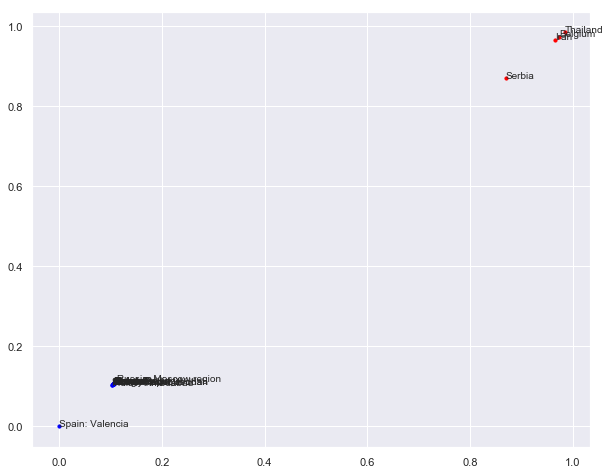

In [95]:
plt.figure(figsize=(10,8))
ax = plt.scatter(X_eu_vs_asia[np.where(clustering_eu_vs_asia==1)[0],0],X_eu_vs_asia[0,np.where(clustering_eu_vs_asia==1)[0]], s=10,c='blue')
plt.scatter(X_eu_vs_asia[np.where(clustering_eu_vs_asia==0)[0],0],X_eu_vs_asia[0,np.where(clustering_eu_vs_asia==0)[0]], s=10,c='red')
for i, txt in enumerate(dm_eu_vs_asia.names):
    plt.annotate(accession_metainfo_eu_vs_asia[accession_metainfo_eu_vs_asia.index.values == txt].Geo_Location.values[0], (X_eu_vs_asia[i,0],X_eu_vs_asia[0,i]))
plt.show()

In [96]:
clusters = pd.DataFrame(data=dm_eu_vs_asia.names, columns=['Accession'])
clusters['clusters'] = clustering_eu_vs_asia
clusters['Geo_Location'] = [accession_metainfo_eu_vs_asia[accession_metainfo_eu_vs_asia.index ==x].Geo_Location.values[0] for x in clusters.Accession]

In [97]:
clusters

,Accession,clusters,Geo_Location
0,MT256917.1,1,Spain: Valencia
1,MT372481.1,1,Malaysia
2,MT093571.1,1,Sweden
3,MT576689.1,1,Bangladesh
4,MT630423.1,1,Saudi Arabia: Jeddah
5,MT470105.1,1,France
6,MT511081.1,1,Poland
7,MT560530.1,1,Turkey
8,MT328033.1,1,Greece
9,MT517422.1,1,Czech Republic


Colours:  {'Asia': 'r', 'Europe': 'g'}


/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:597: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


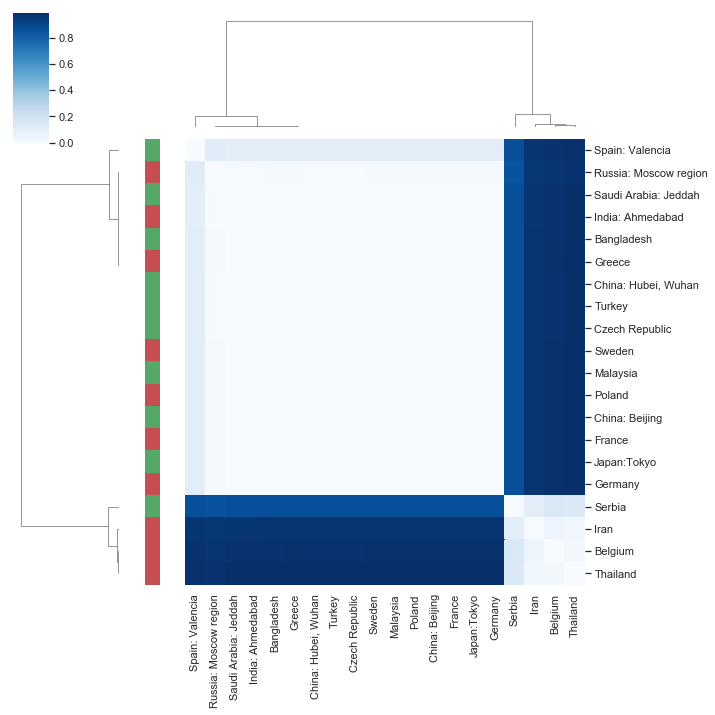

In [98]:
lut = dict(zip(accession_metainfo_eu_vs_asia["Continent"].unique(), "rg"))
lut2 = accession_metainfo_eu_vs_asia["Continent"].map(lut)
row_colors = [lut2[x] for x in dm_eu_vs_asia.names]

#use the UPGMA scoring for clustering
#linkage2 = hc.linkage(sp.distance.squareform(df_eu_vs_asia), method="average")
print("Colours: ", lut)
g = sns.clustermap(df_eu_vs_asia, cmap="Blues", row_colors=row_colors, method="average")#, row_linkage=linkage2, col_linkage=linkage2)

In [99]:
asia_list = accession_metainfo_eu_vs_asia[accession_metainfo_eu_vs_asia["Continent"]=="Asia"]["Geo_Location"].values
europe_list = accession_metainfo_eu_vs_asia[accession_metainfo_eu_vs_asia["Continent"]=="Europe"]["Geo_Location"].values

In [100]:
print("Mean Identity Distance between Europe and Asia:")
print((df_eu_vs_asia.filter(items=europe_list, axis=1).filter(items=asia_list, axis=0).mean().mean() + 
     df_eu_vs_asia.filter(items=asia_list, axis=1).filter(items=europe_list, axis=0).mean().mean()) / 2)
print("Mean Identity Distance in Europe:")
print(df_eu_vs_asia.filter(items=europe_list, axis=1).filter(items=europe_list, axis=0).mean().mean())
print("Mean Identity Distance in Asia:")
print(df_eu_vs_asia.filter(items=asia_list, axis=1).filter(items=asia_list, axis=0).mean().mean())
print("Mean Identity Distance total:")
print(df_eu_vs_asia.mean().mean())

Mean Identity Distance between Europe and Asia:
0.337838343978865
Mean Identity Distance in Europe:
0.17460187941009264
Mean Identity Distance in Asia:
0.4145316523425743
Mean Identity Distance total:
0.31620255492759924
